In [11]:
import networkx as nx
import urllib.parse
import random
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from networkx.algorithms.shortest_paths.dense import floyd_warshall_numpy
import loader as ld
import funcs as fc

from sklearn.metrics.pairwise import cosine_similarity
from collections import deque

In [12]:
paths = ld.load_navigation_paths('data/paths_finished.tsv')
G = ld.load_wikispeedia_graph('data/links.tsv')
page_texts = ld.load_wikispeedia_data("data/plaintext_articles" )

# Find the largest strongly connected component
scc = list(nx.strongly_connected_components(G))
largest_scc = max(scc, key=len)

# Create a subgraph of DG that contains only the nodes in the largest strongly connected component
G_cc = G.subgraph(largest_scc).copy()

# Create a set of nodes in the largest strongly connected component
largest_scc_nodes = set(largest_scc)

# Function to check if a path is entirely within the largest SCC
def path_in_largest_scc(path, largest_scc):
    return all(node in largest_scc for node in path)

# Filter paths to keep only those entirely within the largest SCC
paths_cc = [path for path in paths if path_in_largest_scc(path, largest_scc_nodes)]

In [24]:
# Assuming page_texts is a dictionary with page names as keys and their contents as values
tfidf_matrix, vectorizer = ld.vectorize_texts(page_texts)
page_names = list(page_texts.keys())

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert to a DataFrame
similarity_df = pd.DataFrame(cosine_sim_matrix, index=page_names, columns=page_names)

# Create convenient variables
node_list = list(G_cc.nodes())
node_list_G = list(G.nodes())
pages = list(page_texts.keys())
node_index = {node: index for index, node in enumerate(node_list)}
node_index_G = {node: index for index, node in enumerate(node_list_G)}

In [14]:
output = floyd_warshall_numpy(G)
# Save the results to a file
with open('G_floyd_warshall_results.pkl', 'wb') as file:
    pickle.dump(output, file)

In [16]:
# Degree paths
degree_paths = []
degrees_path_lens = []
for path in paths:
    start = path[0]
    end = path[-1]
    degree = fc.degree_based_search(G, start, end)
    if degree is not None:
        degree_paths.append(degree)
        degrees_path_lens.append(len(degree))


import pickle
# Save the results to a file
with open('G_degree_paths.pkl', 'wb') as file:
    pickle.dump(degree_paths, file)

In [25]:
# Similarity paths
sim_paths = []
sim_path_lens = []
for path in paths:
    start = path[0]
    end = path[-1]
    sim = fc.similarity_based_search(G, start, end, cosine_sim_matrix, node_index_G)
    if sim is not None:
        sim_paths.append(sim)
        sim_path_lens.append(len(sim))

In [ ]:
import pickle
# Save the results to a file
with open('G_similarity_paths.pkl', 'wb') as file:
    pickle.dump(sim_paths, file)

In [32]:
# Load the results from the file
with open('floyd_warshall_results_gcc.pkl', 'rb') as file:
    dist_loaded = pickle.load(file)

In [33]:
# Load the results from the file
with open('degree_paths.pkl', 'rb') as file:
    degree_paths = pickle.load(file)
degrees_path_lens = []
for path in degree_paths:
    degrees_path_lens.append(len(path))

In [34]:
# Load the results from the file
with open('similarity_paths.pkl', 'rb') as file:
    sim_paths = pickle.load(file)
sim_path_lens = []
for path in sim_paths:
    sim_path_lens.append(len(path))

In [42]:
# random based search
def random_search(G, start, end):
    # Early exit if start is the same as end
    if start == end:
        return [start]
    
    if start not in G or end not in G:
        return None  # Return None if either node doesn't exist

    # Initialize a queue for BFS
    queue = deque([(start, [start])])
    # Set to keep track of visited nodes
    visited = set([start])

    while queue:
        # Pop the first element in the queue
        current_node, path = queue.popleft()

        # Get neighbors and sort them based on degree (descending order)
        neighbors = sorted(G.neighbors(current_node), key=G.degree, reverse=True)
        random.shuffle(neighbors)

        for neighbor in neighbors:
            if neighbor == end:
                return path + [end]
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))

    return None  # If no path is found

In [55]:
def search_algo(G, s, t):
    stack = [s]
    visited = []
    while stack:
        u = stack.pop()
        visited.append(u)
        if (u == t):
            return visited
        elif u not in visited[:-1]:
            sort_n = sorted(G.neighbors(u), key=G.out_degree, reverse=False)
            for u_dash in sort_n:
                stack.append(u_dash)
                if (u_dash == t):
                    break
    return 'nopathbetweensandtexists'

In [56]:
#random paths
rand = []
rand_len = []
for path in paths_cc[:3]:
    start = path[0]
    end = path[-1]
    sim = search_algo(G, start, end)
    if sim is not None:
        rand.append(sim)
        rand_len.append(len(sim))

In [57]:
# print(len(user_path_lens))
# print(len(best_path_lens))
print(np.mean(rand_len))
print(len(degree_paths))
print(len(sim_paths))
print(np.mean(degrees_path_lens[:100]))
print(np.mean(sim_path_lens[:100]))

1562.0
51317
51317
3.92
3.92


In [35]:
# Evaluate user paths
dist_arg = node_index, dist_loaded

# Evaluate user paths
user_path_lens = []
best_path_lens = []
ratios = []
for path in path:
    start = path[0]
    end = path[-1]
    user = len(path)
    best = fc.get_distance(start, end, dist_arg)
    if best is not None and not np.isinf(best):
        user_path_lens.append(user)
        best_path_lens.append(best)
        if (best > 0):
            ratios.append(user/best)



In [36]:
print(np.max(best_path_lens))
np_dbs_path = np.array(degrees_path_lens)
np_best_path = np.array(best_path_lens)
np_user_path = np.array(user_path_lens)

# Boolean mask where neither array has a 0 value
mask = (np_dbs_path != 0) & (np_user_path != 0)

# Apply mask to both arrays
np_dbs_path = np_dbs_path[mask]
np_user_path = np_user_path[mask]

# Perform division
dbs_ratios =  np_user_path/np_dbs_path
print(np.mean(dbs_ratios))

6.0
1.5080693255936486


In [37]:
print(len(user_path_lens))
print(len(best_path_lens))
print(len(degree_paths))
print(len(sim_paths))

41936
41936
41936
41936


In [38]:
# Function to compute text similarity between two pages
def compute_similarity(page1, page2):
    # Get the indices of the pages in the TF-IDF matrix
    index1 = node_index[page1]
    index2 = node_index[page2]
    similarity = cosine_sim_matrix[index1][index2]
    return similarity

In [39]:
# Step 1: Calculate the degree of each node
node_degrees = dict(G_cc.degree())
user_path_5 = [path for path in paths_cc if len(path) == 5]
sim_path_5 = [path for path in sim_paths if len(path) == 5]
deg_path_5 = [path for path in degree_paths if len(path) == 5]

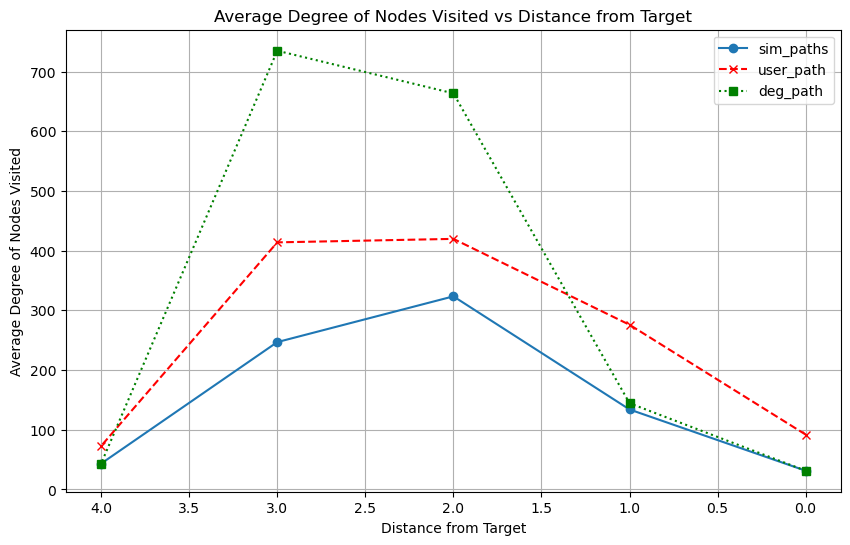

In [40]:
def calculate_average_degrees(paths):
    distance_dict = {}
    for path in paths:
        reversed_path = list(reversed(path))
        for distance, node in enumerate(reversed_path):
            if distance not in distance_dict:
                distance_dict[distance] = []
            distance_dict[distance].append(node)
    
    avg_degrees = []
    distances = sorted(distance_dict.keys())
    for distance in distances:
        degrees = [node_degrees[node] for node in distance_dict[distance]]
        avg_degree = np.mean(degrees)
        avg_degrees.append(avg_degree)
    
    return distances, avg_degrees

# Calculate average degrees for each path set
sim_distances, sim_avg_degrees = calculate_average_degrees(sim_path_5)
user_distances, user_avg_degrees = calculate_average_degrees(user_path_5)
deg_distances, deg_avg_degrees = calculate_average_degrees(deg_path_5)

# Step 4: Plot the results with flipped x-axis
plt.figure(figsize=(10, 6))
plt.plot(sim_distances, sim_avg_degrees, marker='o', label='sim_paths')
plt.plot(user_distances, user_avg_degrees, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(deg_distances, deg_avg_degrees, marker='s', linestyle=':', label='deg_path', color='green')
plt.xlabel('Distance from Target')
plt.ylabel('Average Degree of Nodes Visited')
plt.title('Average Degree of Nodes Visited vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.grid(True)
plt.savefig('avg_deg', bbox_inches='tight')
plt.show()

In [41]:
def compute_similarity_at_each_distance(paths):
    distance_dict = {}
    
    for path in paths:
        final_node = path[-1]
        reversed_path = list(reversed(path[:-1]))
        
        for distance, node in enumerate(reversed_path):
            similarity = compute_similarity(node, final_node)
            
            if distance not in distance_dict:
                distance_dict[distance] = []
            distance_dict[distance].append(similarity)
    
    avg_similarities = []
    distances = sorted(distance_dict.keys())
    for distance in distances:
        avg_similarity = np.mean(distance_dict[distance])
        avg_similarities.append(avg_similarity)
    
    return distances, avg_similarities

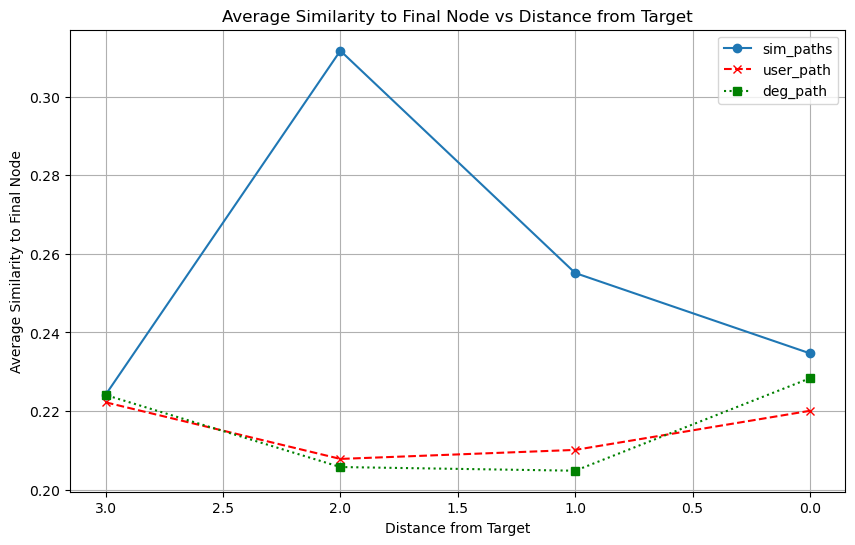

In [42]:
# Compute the average similarity at each distance for the paths
sim_distances, sim_avg_similarities = compute_similarity_at_each_distance(sim_path_5)
user_distances, user_avg_similarities = compute_similarity_at_each_distance(user_path_5)
deg_distances, deg_avg_similarities = compute_similarity_at_each_distance(deg_path_5)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sim_distances, sim_avg_similarities, marker='o', label='sim_paths')
plt.plot(user_distances, user_avg_similarities, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(deg_distances, deg_avg_similarities, marker='s', linestyle=':', label='deg_path', color='green')
plt.xlabel('Distance from Target')
plt.ylabel('Average Similarity to Final Node')
plt.title('Average Similarity to Final Node vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.grid(True)
plt.savefig('sim_paths', bbox_inches = 'tight')
plt.show()

In [43]:
def path_similarity(path1, path2):
    # Determine the shorter and longer path
    if len(path1) <= len(path2):
        shorter_path, longer_path = path1, path2
    else:
        shorter_path, longer_path = path2, path1
    
    # Initialize the count of matching jumps
    matching_jumps = 0
    
    # Compare jumps in the shorter path with the corresponding jumps in the longer path
    for i in range(len(shorter_path) - 1):
        if shorter_path[i:i+2] == longer_path[i:i+2]:
            matching_jumps += 1
    
    return matching_jumps

print(path_similarity(paths_cc[1], sim_paths[0]))
total = 0
for i in range(len(paths_cc)):
    s = path_similarity(paths_cc[i], sim_paths[i])
    if (s > 0):
        total += s
        # print(i, paths_cc[i], sim_paths[i], '\n')
new = sum(len(x) for x in paths_cc)
print(total/new)

0
0.05317618807402559


In [44]:
total = 0
for i in range(len(paths_cc)):
    s = path_similarity(paths_cc[i], degree_paths[i])
    if (s > 0):
        total += s
print(total/new)

0.07144911887202278


In [45]:
# import numpy as np
# import networkx as nx
# import pandas as pd

# def compute_node_appearance_matrix(paths, G):
#     nodes = list(G.nodes())
#     node_index = {node: idx for idx, node in enumerate(nodes)}
#     appearance_counts = np.zeros((len(nodes), len(nodes)))

#     # Count appearances
#     for path in paths:
#         target_node = path[-1]
#         if target_node in node_index:
#             target_idx = node_index[target_node]
#             for node in path:
#                 if node in node_index:
#                     node_idx = node_index[node]
#                     appearance_counts[node_idx][target_idx] += 1

#     # Normalize to get probabilities
#     appearance_probabilities = np.zeros_like(appearance_counts)
#     for target_idx in range(len(nodes)):
#         total_appearances = np.sum(appearance_counts[:, target_idx])
#         if total_appearances > 0:
#             appearance_probabilities[:, target_idx] = appearance_counts[:, target_idx] / total_appearances

#     return appearance_probabilities

# appearance_matrix = compute_node_appearance_matrix(paths_cc, G_cc)

In [46]:
# import pickle
# # Save the results to a file
# with open('appearance_matrix.pkl', 'wb') as file:
#     pickle.dump(appearance_matrix, file)
# Load the results from the file
with open('appearance_matrix.pkl', 'rb') as file:
    appearance_matrix = pickle.load(file)

In [47]:
import numpy as np
import networkx as nx
from collections import deque

def conn_search(G, start, end):
    # Early exit if start is the same as end
    if start == end:
        return [start]

    if start not in G or end not in G:
        return None  # Return None if either node doesn't exist

    # Initialize a queue for BFS
    queue = deque([(start, [start])])
    # Set to keep track of visited nodes
    visited = set([start])

    while queue:
        # Pop the first element in the queue
        current_node, path = queue.popleft()

        # Get neighbors and sort them based on a hybrid score
        end_index = node_index[end]
        neighbors = G.neighbors(current_node)
        neighbor_scores = []

        for neighbor in neighbors:
            similarity_score = cosine_sim_matrix[node_index[neighbor], end_index]
            appearance_score = appearance_matrix[node_index[neighbor], end_index]
            hybrid_score = appearance_score  # Equal weighting of both scores
            neighbor_scores.append((neighbor, hybrid_score))

        neighbors_sorted = sorted(neighbor_scores, key=lambda x: x[1], reverse=True)

        for neighbor, _ in neighbors_sorted:
            if neighbor == end:
                return path + [end]
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))

    return None  # If no path is found


In [50]:
conn_paths = []
conn_path_lens = []
for path in paths_cc:
    start = path[0]
    end = path[-1]
    conn = conn_search(G_cc, start, end)
    if conn is not None and not np.isinf(best):
        conn_paths.append(conn)
        conn_path_lens.append(len(conn))


import pickle
# Save the results to a file
with open('conn_paths.pkl', 'wb') as file:
    pickle.dump(conn_paths, file)
print(len(conn_paths))

41936


In [35]:
conn_path_5 = [path for path in conn_paths if len(path) == 5]
np.mean(conn_path_lens)

3.646

In [36]:
import numpy as np
import networkx as nx
from collections import deque

def hybrid_search(G, start, end):
    # Early exit if start is the same as end
    if start == end:
        return [start]

    if start not in G or end not in G:
        return None  # Return None if either node doesn't exist

    # Initialize a queue for BFS
    queue = deque([(start, [start])])
    # Set to keep track of visited nodes
    visited = set([start])

    while queue:
        # Pop the first element in the queue
        current_node, path = queue.popleft()

        # Get neighbors and sort them based on a hybrid score
        end_index = node_index[end]
        neighbors = G.neighbors(current_node)
        neighbor_scores = []

        for neighbor in neighbors:
            similarity_score = cosine_sim_matrix[node_index[neighbor], end_index]
            appearance_score = appearance_matrix[node_index[neighbor], end_index]
            hybrid_score = similarity_score * 0.5 + appearance_score * 0.5  # Equal weighting of both scores
            neighbor_scores.append((neighbor, hybrid_score))

        neighbors_sorted = sorted(neighbor_scores, key=lambda x: x[1], reverse=True)

        for neighbor, _ in neighbors_sorted:
            if neighbor == end:
                return path + [end]
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path + [neighbor]))

    return None  # If no path is found


In [37]:
# Degree paths
hyb_paths = []
hyb_path_lens = []
for path in paths_cc:
    start = path[0]
    end = path[-1]
    degree = hybrid_search(G_cc, start, end)
    if degree is not None and not np.isinf(best):
        hyb_paths.append(degree)
        hyb_path_lens.append(len(degree))


import pickle
# Save the results to a file
with open('hybrid_paths.pkl', 'wb') as file:
    pickle.dump(hyb_paths, file)


KeyboardInterrupt: 

In [38]:
# Load the results from the file
with open('hybrid_paths.pkl', 'rb') as file:
    hyb_paths = pickle.load(file)

In [39]:
print(np.mean(best_path_lens))
print(np.mean(degrees_path_lens))
print(np.mean(hyb_path_lens))
print(np.mean(user_path_lens))
print(np.mean(conn_path_lens))

2.8001001526135063
3.8001001526135063
3.6639624252775405
5.719739603204884
3.646


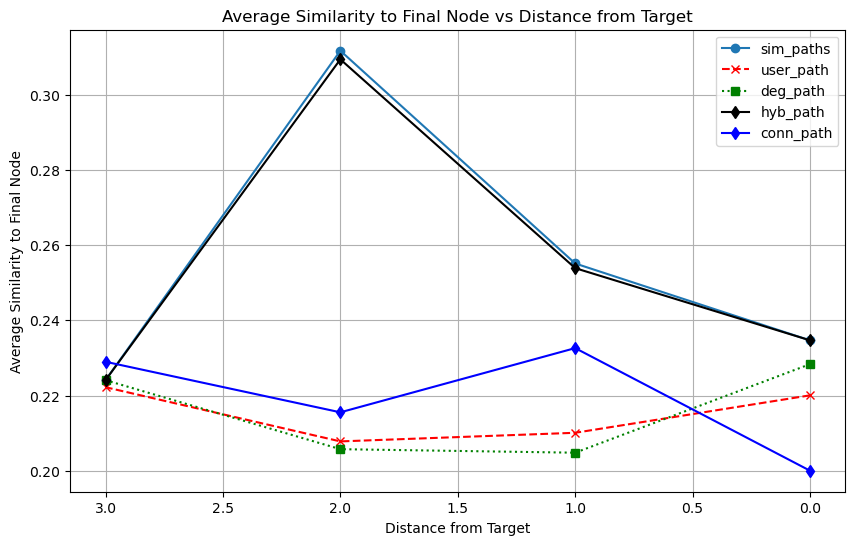

In [40]:
# Compute the average similarity at each distance for the paths
hyb_path_5 = [path for path in hyb_paths if len(path) == 5]
conn_distances, con_avg_similarities = compute_similarity_at_each_distance(conn_path_5)
sim_distances, sim_avg_similarities = compute_similarity_at_each_distance(sim_path_5)
user_distances, user_avg_similarities = compute_similarity_at_each_distance(user_path_5)
deg_distances, deg_avg_similarities = compute_similarity_at_each_distance(deg_path_5)
hyp_distances, hyp_avg_similarities = compute_similarity_at_each_distance(hyb_path_5)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sim_distances, sim_avg_similarities, marker='o', label='sim_paths')
plt.plot(user_distances, user_avg_similarities, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(deg_distances, deg_avg_similarities, marker='s', linestyle=':', label='deg_path', color='green')
plt.plot(hyp_distances, hyp_avg_similarities, marker='d', linestyle='-', label='hyb_path', color='black')
plt.plot(conn_distances, con_avg_similarities, marker='d', linestyle='-', label='conn_path', color='blue')
plt.xlabel('Distance from Target')
plt.ylabel('Average Similarity to Final Node')
plt.title('Average Similarity to Final Node vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.grid(True)
plt.savefig('sim_paths', bbox_inches = 'tight')
plt.show()

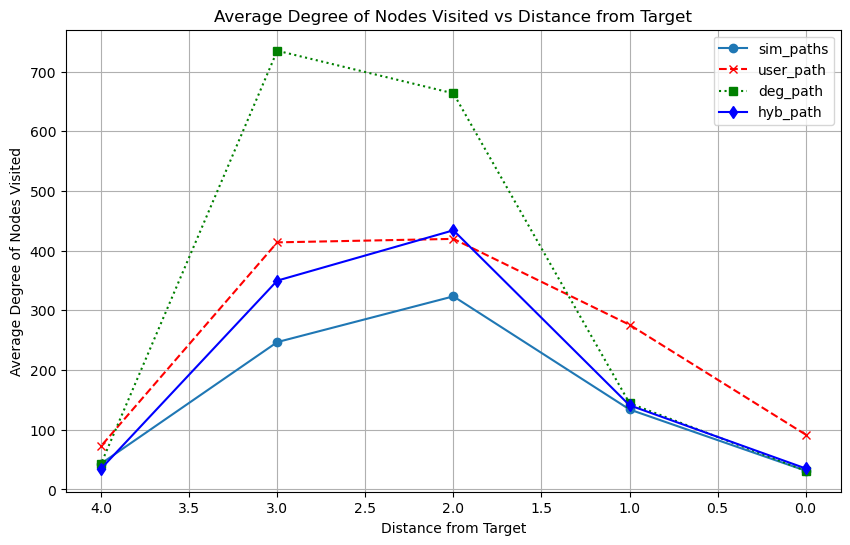

In [41]:
def calculate_average_degrees(paths):
    distance_dict = {}
    for path in paths:
        reversed_path = list(reversed(path))
        for distance, node in enumerate(reversed_path):
            if distance not in distance_dict:
                distance_dict[distance] = []
            distance_dict[distance].append(node)
    
    avg_degrees = []
    distances = sorted(distance_dict.keys())
    for distance in distances:
        degrees = [node_degrees[node] for node in distance_dict[distance]]
        avg_degree = np.mean(degrees)
        avg_degrees.append(avg_degree)
    
    return distances, avg_degrees

# Calculate average degrees for each path set
sim_distances, sim_avg_degrees = calculate_average_degrees(sim_path_5)
user_distances, user_avg_degrees = calculate_average_degrees(user_path_5)
deg_distances, deg_avg_degrees = calculate_average_degrees(deg_path_5)
hyp_distances, hyp_avg_degrees = calculate_average_degrees(hyb_path_5)
conn_distances, conn_avg_degreess = calculate_average_degrees(conn_path_5)

# Step 4: Plot the results with flipped x-axis
plt.figure(figsize=(10, 6))
plt.plot(sim_distances, sim_avg_degrees, marker='o', label='sim_paths')
plt.plot(user_distances, user_avg_degrees, marker='x', linestyle='--', label='user_path', color='red')
plt.plot(deg_distances, deg_avg_degrees, marker='s', linestyle=':', label='deg_path', color='green')
plt.plot(conn_distances, conn_avg_degreess, marker='d', linestyle='-', label='hyb_path', color='blue')
plt.xlabel('Distance from Target')
plt.ylabel('Average Degree of Nodes Visited')
plt.title('Average Degree of Nodes Visited vs Distance from Target')
plt.legend()
plt.gca().invert_xaxis()  # Flip the x-axis so distance 0 is on the right
plt.grid(True)
plt.savefig('avg_deg', bbox_inches='tight')
plt.show()

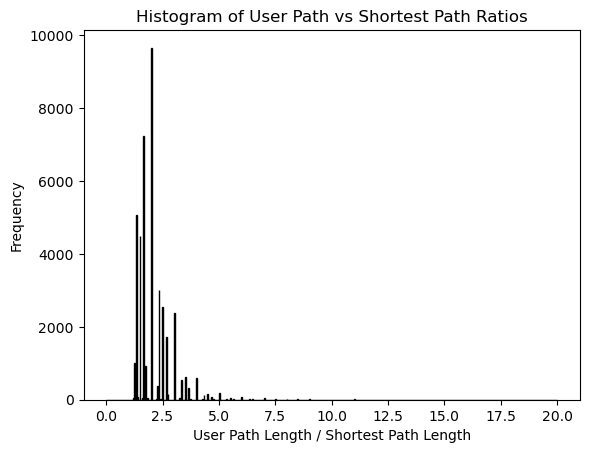

In [42]:
# Plot the histogram
plt.hist(ratios, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('User Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs Shortest Path Ratios')
plt.savefig('best_hist', bbox_inches='tight')
plt.show()

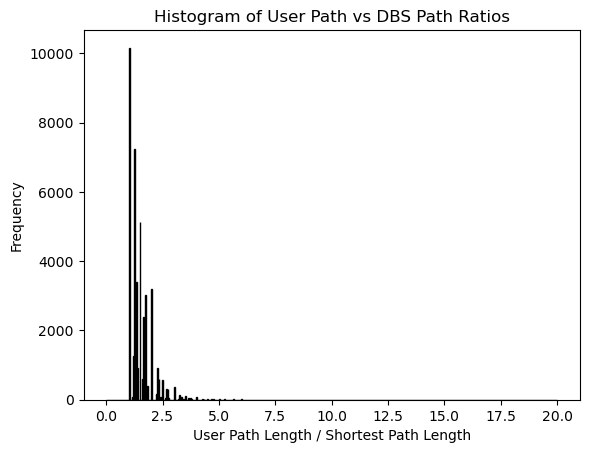

In [43]:
# Plot the histogram
plt.hist(dbs_ratios, bins=500, edgecolor='black', range=(0,20))
plt.xlabel('User Path Length / Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Histogram of User Path vs DBS Path Ratios')
plt.savefig('dbs_his', bbox_inches='tight')
plt.show()

In [44]:
print(len(hyb_paths))

41936


In [60]:
# import random
# import pickle

# # Assuming G is your original graph
# # nodes = random.sample(G.nodes(), 50) # Use this if you want a random sample of 500 nodes
# nodes = list(G_cc.nodes())   # Use this if you want the first 500 nodes

# # Create a subgraph using the selected nodes
# subgraph = G_cc.subgraph(nodes)


# all_pairs_shortest_paths = dict(nx.all_pairs_shortest_path(subgraph))

# # Save the results to a file
# with open('all_pairs_shortest_paths.pkl', 'wb') as file:
#     pickle.dump(all_pairs_shortest_paths, file)

In [11]:
# Load the results from the file
with open('all_pairs_shortest_paths.pkl', 'rb') as file:
    all_pairs_shortest_paths = pickle.load(file)

In [12]:
print(all_pairs_shortest_paths['George_Washington']['Philosophiae_Naturalis_Principia_Mathematica'])

['George_Washington', 'Thomas_Jefferson', 'Isaac_Newton', 'Philosophiae_Naturalis_Principia_Mathematica']
